<a href="https://colab.research.google.com/github/Qiaochu-Zhang/C-_Grades_with_Hash_Table/blob/main/basic1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pip install torch torchvision
!pip install opencv-python
!pip install scikit-learn


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import cv2
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import KFold
import random


In [24]:
# 检查是否有GPU可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [25]:
# 自定义数据集类，提取噪声作为输入
class NoiseDataset(Dataset):
    def __init__(self, image_folder, label):
        self.image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
        self.labels = [label] * len(self.image_paths)
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

    def extract_noise(self, image_path):
        """提取图片的噪声特征"""
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            # 如果无法读取图像，返回None
            return None
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        noise = cv2.absdiff(img, blurred)  # 计算噪声图
        return Image.fromarray(noise)  # 转换为 PIL 格式

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 提取噪声图像
        noise_image = self.extract_noise(self.image_paths[idx])
        if noise_image is None:
            # 如果无法读取图像，则跳过该样本
            return self.__getitem__((idx + 1) % len(self.image_paths))
        img_tensor = self.transform(noise_image)
        label = self.labels[idx]
        return img_tensor, label


In [27]:
# 定义数据集路径
real_images_path = '/content/drive/MyDrive/Real'  # 请根据您的实际路径调整
ai_images_path = '/content/drive/MyDrive/fake'   # 请根据您的实际路径调整

# 加载数据集：真实图片和AI生成图片
real_dataset = NoiseDataset(real_images_path, label=0)
ai_dataset = NoiseDataset(ai_images_path, label=1)

# 合并数据集
full_dataset = real_dataset + ai_dataset

# 打乱数据集
random.seed(42)
indices = list(range(len(full_dataset)))
random.shuffle(indices)
full_dataset = Subset(full_dataset, indices)

print(f"Total dataset size: {len(full_dataset)}")


Total dataset size: 425


In [28]:
# 定义K折交叉验证
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)


In [29]:
# 定义 CNN 模型
class NoiseCNN(nn.Module):
    def __init__(self):
        super(NoiseCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # 输入为灰度图 (1通道)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)  # 输出为2类：真实或AI生成

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)  # 展平张量
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [30]:
# 准备交叉验证
results = {}
num_epochs = 10

for fold, (train_ids, val_ids) in enumerate(kfold.split(range(len(full_dataset)))):
    print(f'\nFold {fold + 1}')
    print('--------------------------------')

    # 定义训练和验证数据集
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    # 定义数据加载器
    train_loader = torch.utils.data.DataLoader(
                      full_dataset,
                      batch_size=8, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(
                      full_dataset,
                      batch_size=8, sampler=val_subsampler)

    # 初始化模型、损失函数和优化器
    model = NoiseCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 开始训练
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # 验证模型
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    print(f'Fold {fold + 1} Accuracy: {accuracy:.2f}%')

    # 保存结果
    results[fold] = accuracy



Fold 1
--------------------------------
Epoch [1/10], Loss: 0.6986
Epoch [2/10], Loss: 0.6938
Epoch [3/10], Loss: 0.6806
Epoch [4/10], Loss: 0.6391
Epoch [5/10], Loss: 0.5540
Epoch [6/10], Loss: 0.4795
Epoch [7/10], Loss: 0.3780
Epoch [8/10], Loss: 0.2778
Epoch [9/10], Loss: 0.2447
Epoch [10/10], Loss: 0.2305
Fold 1 Accuracy: 86.05%

Fold 2
--------------------------------
Epoch [1/10], Loss: 0.7086
Epoch [2/10], Loss: 0.6953
Epoch [3/10], Loss: 0.6894
Epoch [4/10], Loss: 0.6772
Epoch [5/10], Loss: 0.6296
Epoch [6/10], Loss: 0.5620
Epoch [7/10], Loss: 0.4475
Epoch [8/10], Loss: 0.3925
Epoch [9/10], Loss: 0.2845
Epoch [10/10], Loss: 0.2164
Fold 2 Accuracy: 88.37%

Fold 3
--------------------------------
Epoch [1/10], Loss: 0.6916
Epoch [2/10], Loss: 0.6752
Epoch [3/10], Loss: 0.6468
Epoch [4/10], Loss: 0.5654
Epoch [5/10], Loss: 0.4806
Epoch [6/10], Loss: 0.3301
Epoch [7/10], Loss: 0.2595
Epoch [8/10], Loss: 0.1913
Epoch [9/10], Loss: 0.1874
Epoch [10/10], Loss: 0.1781
Fold 3 Accuracy:

In [31]:
# 打印每个折的结果
print('\nK-FOLD CROSS VALIDATION RESULTS')
print('--------------------------------')
sum_acc = 0.0
for key, value in results.items():
    print(f'Fold {key + 1}: {value:.2f}%')
    sum_acc += value
print(f'Average Accuracy: {sum_acc/len(results):.2f}%')



K-FOLD CROSS VALIDATION RESULTS
--------------------------------
Fold 1: 86.05%
Fold 2: 88.37%
Fold 3: 97.67%
Fold 4: 83.72%
Fold 5: 97.67%
Fold 6: 90.48%
Fold 7: 78.57%
Fold 8: 85.71%
Fold 9: 92.86%
Fold 10: 76.19%
Average Accuracy: 87.73%



Fold 1
--------------------------------
Epoch [1/10], Loss: 0.7126
Validation Accuracy: 51.76%
Epoch [2/10], Loss: 0.6937
Validation Accuracy: 48.24%
Epoch [3/10], Loss: 0.6926
Validation Accuracy: 48.24%
Epoch [4/10], Loss: 0.6922
Validation Accuracy: 48.24%
Epoch [5/10], Loss: 0.6913
Validation Accuracy: 48.24%
Epoch [6/10], Loss: 0.6981
Validation Accuracy: 48.24%
Epoch [7/10], Loss: 0.6919
Validation Accuracy: 48.24%
Epoch [8/10], Loss: 0.6819
Validation Accuracy: 48.24%
Epoch [9/10], Loss: 0.6957
Validation Accuracy: 48.24%
Epoch [10/10], Loss: 0.6963
Validation Accuracy: 60.00%


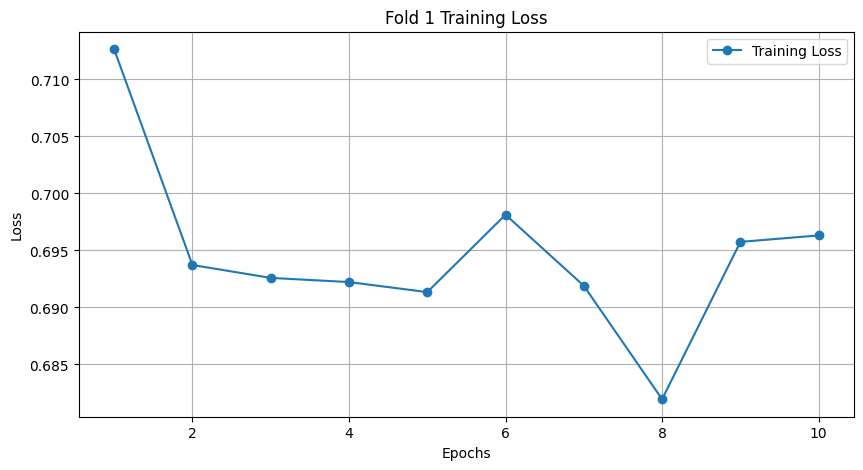

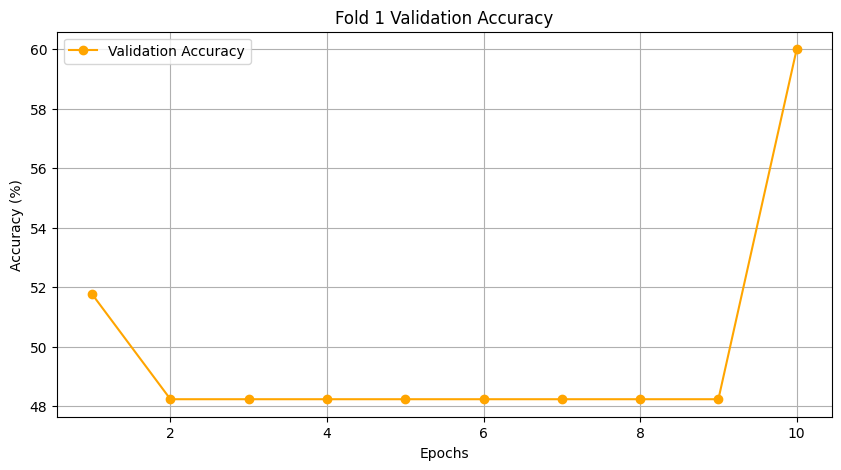

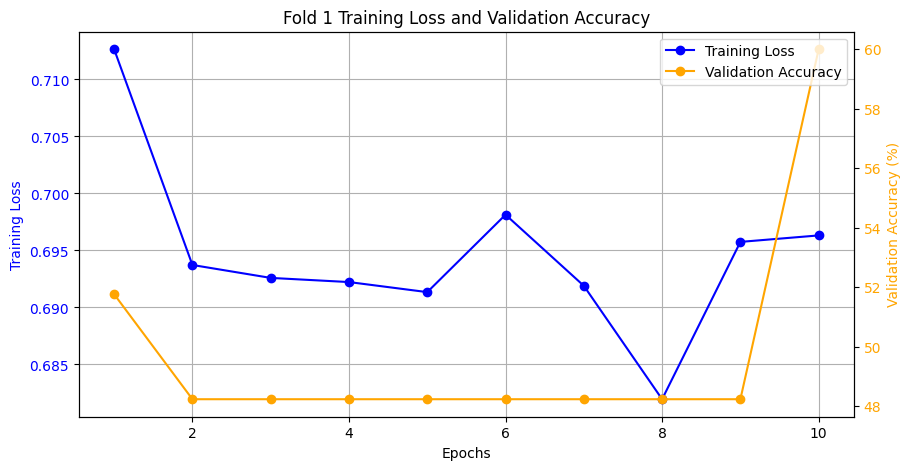


Fold 2
--------------------------------
Epoch [1/10], Loss: 0.7004
Validation Accuracy: 52.94%
Epoch [2/10], Loss: 0.6922
Validation Accuracy: 52.94%
Epoch [3/10], Loss: 0.6934
Validation Accuracy: 52.94%
Epoch [4/10], Loss: 0.6930
Validation Accuracy: 52.94%
Epoch [5/10], Loss: 0.6921
Validation Accuracy: 52.94%
Epoch [6/10], Loss: 0.6932
Validation Accuracy: 52.94%
Epoch [7/10], Loss: 0.6925
Validation Accuracy: 52.94%
Epoch [8/10], Loss: 0.6919
Validation Accuracy: 52.94%
Epoch [9/10], Loss: 0.6947
Validation Accuracy: 52.94%
Epoch [10/10], Loss: 0.6910
Validation Accuracy: 52.94%


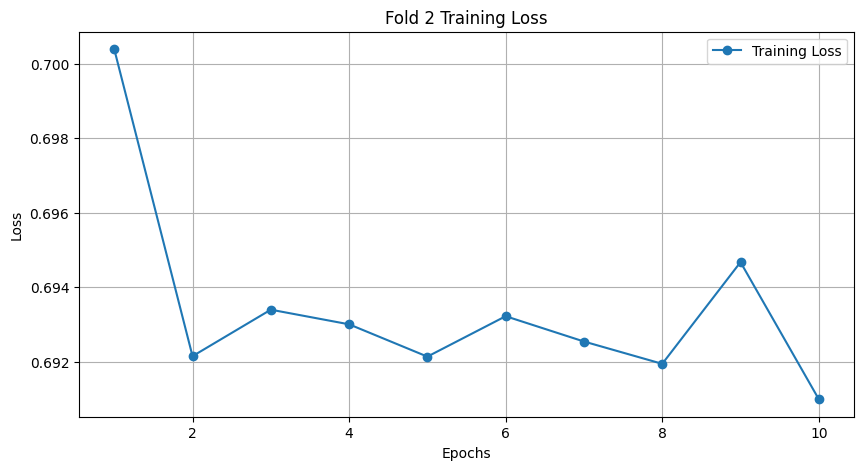

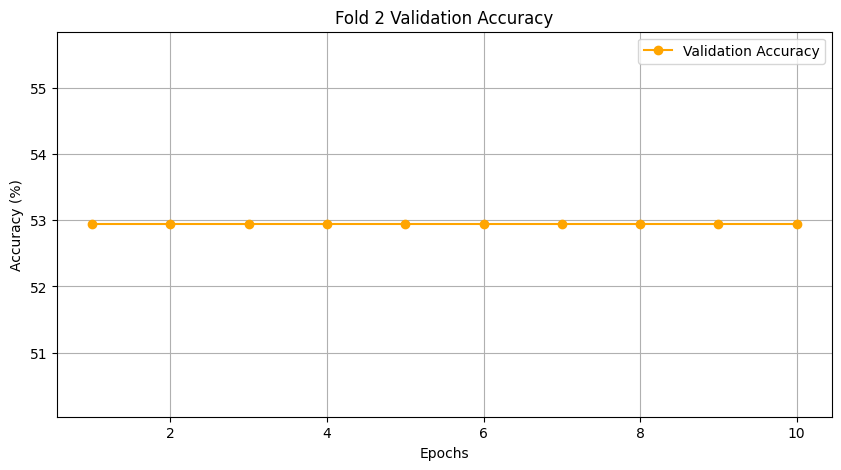

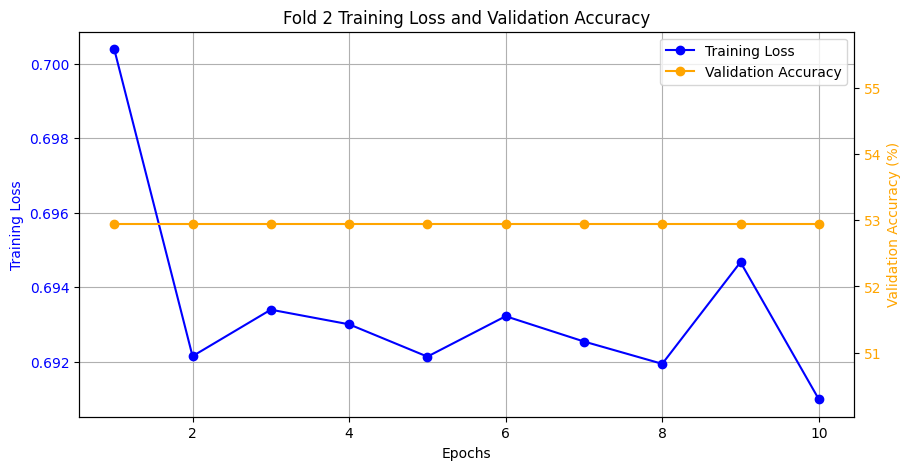


Fold 3
--------------------------------
Epoch [1/10], Loss: 0.7043
Validation Accuracy: 51.76%
Epoch [2/10], Loss: 0.6923
Validation Accuracy: 48.24%
Epoch [3/10], Loss: 0.6955
Validation Accuracy: 51.76%
Epoch [4/10], Loss: 0.6869
Validation Accuracy: 68.24%
Epoch [5/10], Loss: 0.6571
Validation Accuracy: 75.29%
Epoch [6/10], Loss: 0.5692
Validation Accuracy: 81.18%
Epoch [7/10], Loss: 0.4167
Validation Accuracy: 85.88%
Epoch [8/10], Loss: 0.2711
Validation Accuracy: 87.06%
Epoch [9/10], Loss: 0.2024
Validation Accuracy: 94.12%
Epoch [10/10], Loss: 0.1637
Validation Accuracy: 90.59%


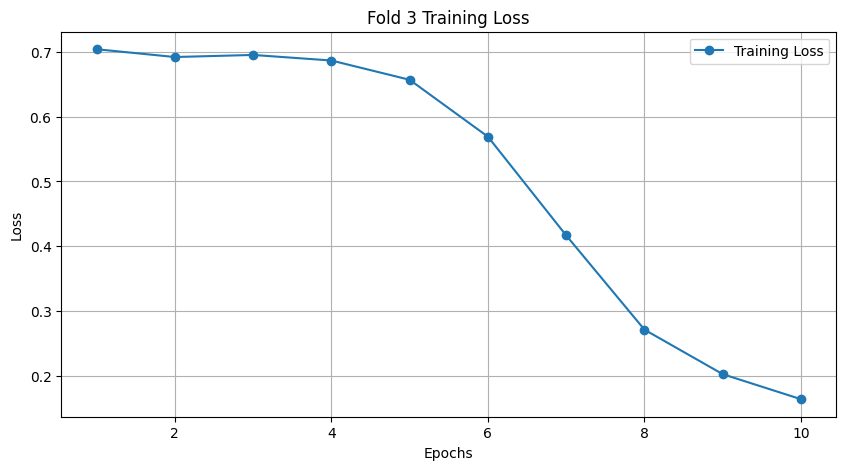

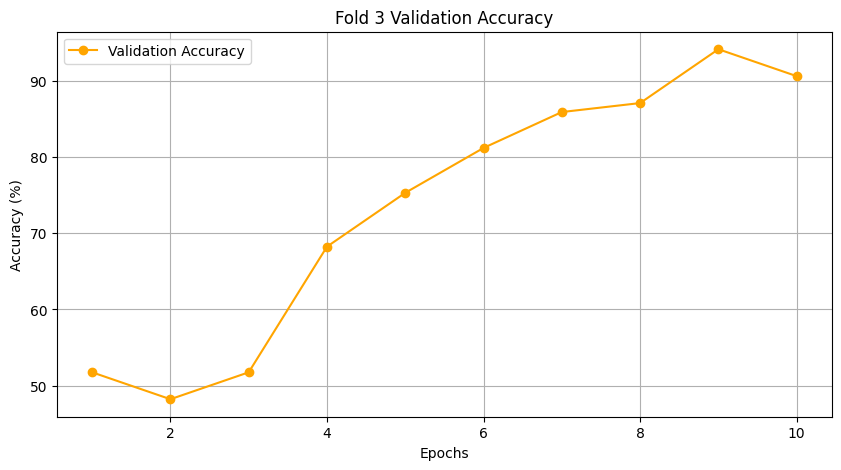

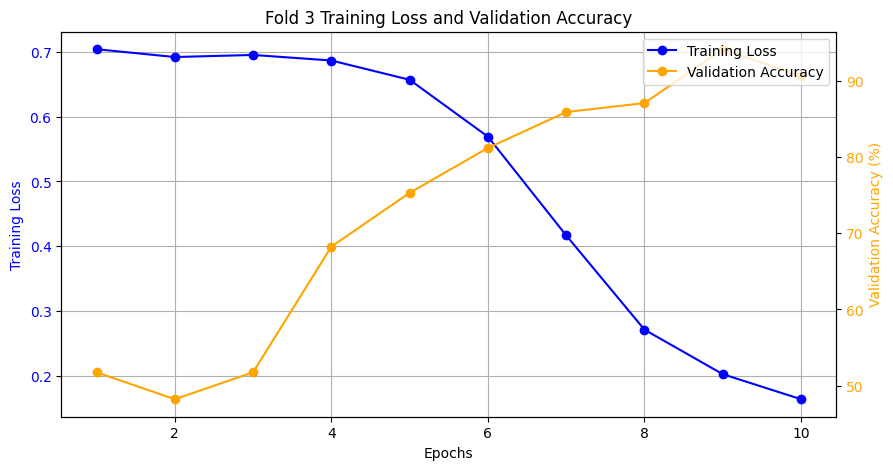


Fold 4
--------------------------------
Epoch [1/10], Loss: 0.7236
Validation Accuracy: 45.88%
Epoch [2/10], Loss: 0.6903
Validation Accuracy: 45.88%
Epoch [3/10], Loss: 0.6878
Validation Accuracy: 45.88%
Epoch [4/10], Loss: 0.6566
Validation Accuracy: 62.35%
Epoch [5/10], Loss: 0.5758
Validation Accuracy: 70.59%
Epoch [6/10], Loss: 0.4672
Validation Accuracy: 75.29%
Epoch [7/10], Loss: 0.3506
Validation Accuracy: 81.18%
Epoch [8/10], Loss: 0.2338
Validation Accuracy: 81.18%
Epoch [9/10], Loss: 0.2158
Validation Accuracy: 80.00%
Epoch [10/10], Loss: 0.1707
Validation Accuracy: 76.47%


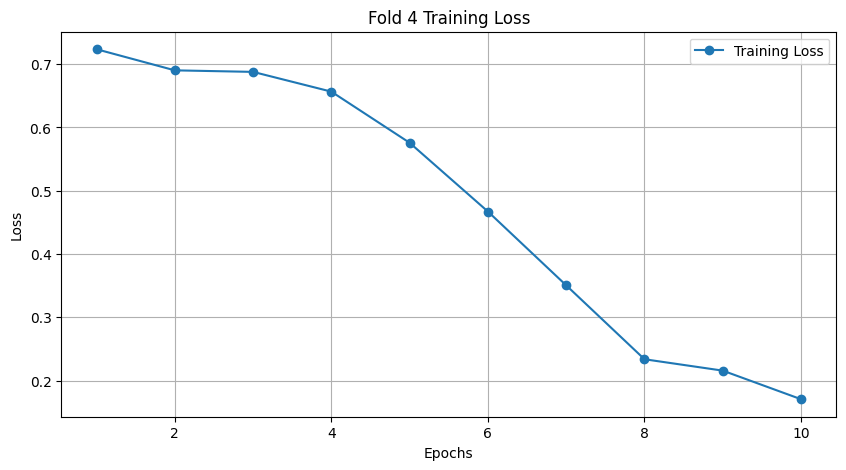

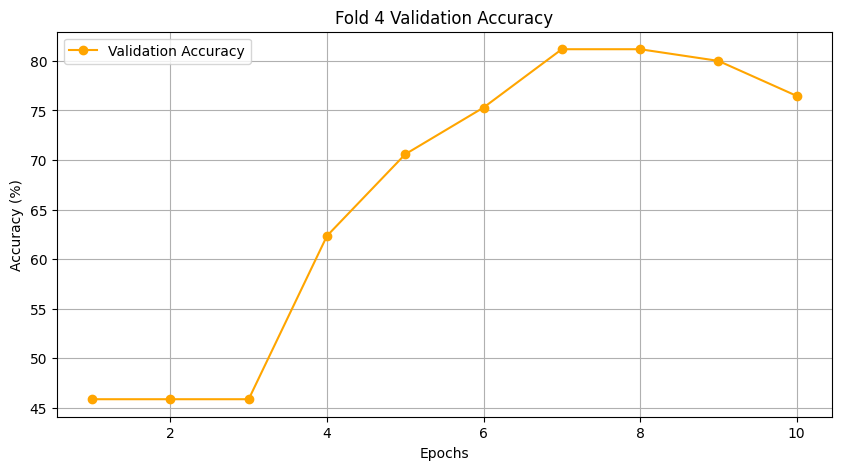

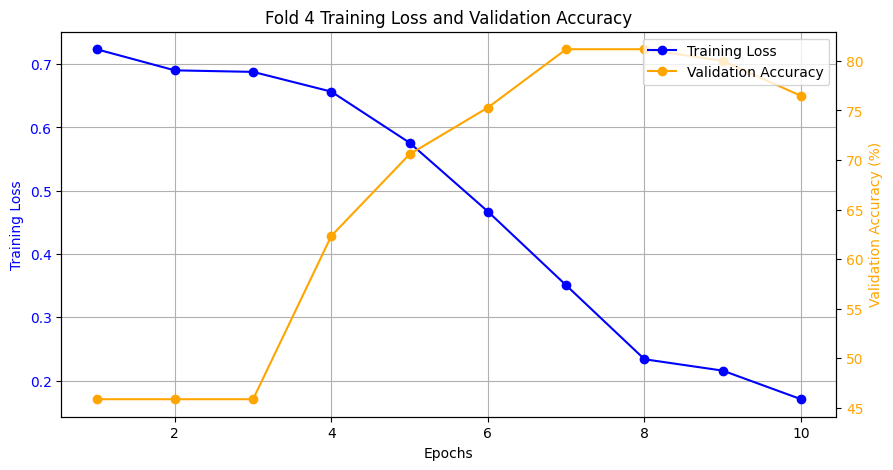


Fold 5
--------------------------------
Epoch [1/10], Loss: 0.6982
Validation Accuracy: 62.35%
Epoch [2/10], Loss: 0.6934
Validation Accuracy: 37.65%
Epoch [3/10], Loss: 0.6932
Validation Accuracy: 62.35%
Epoch [4/10], Loss: 0.6950
Validation Accuracy: 37.65%
Epoch [5/10], Loss: 0.6934
Validation Accuracy: 37.65%
Epoch [6/10], Loss: 0.6936
Validation Accuracy: 62.35%
Epoch [7/10], Loss: 0.6917
Validation Accuracy: 74.12%
Epoch [8/10], Loss: 0.6924
Validation Accuracy: 88.24%
Epoch [9/10], Loss: 0.6765
Validation Accuracy: 50.59%
Epoch [10/10], Loss: 0.5550
Validation Accuracy: 56.47%


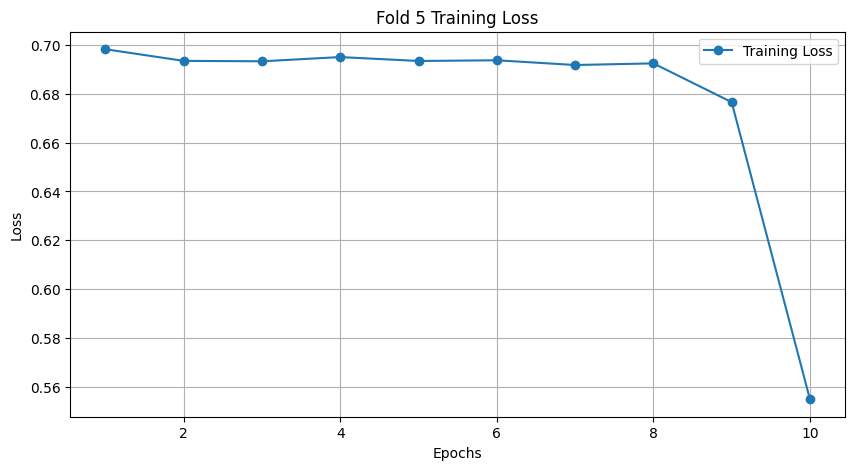

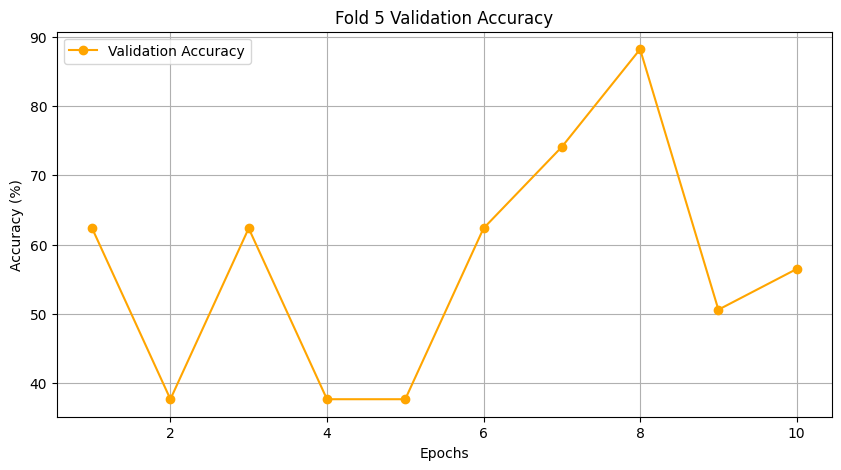

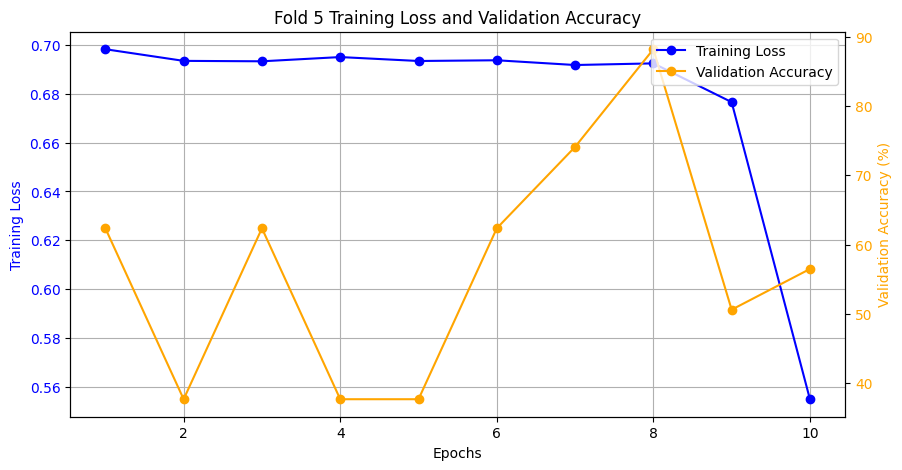

In [32]:
# Step 7: 准备交叉验证并训练模型
import matplotlib.pyplot as plt

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = {}
num_epochs = 10

for fold, (train_ids, val_ids) in enumerate(kfold.split(range(len(full_dataset)))):
    print(f'\nFold {fold + 1}')
    print('--------------------------------')

    # 在fold开始时，初始化列表用于保存训练损失和验证准确率
    train_losses = []
    val_accuracies = []

    # 定义训练和验证数据集
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    # 定义数据加载器
    train_loader = torch.utils.data.DataLoader(
                      full_dataset,
                      batch_size=8, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(
                      full_dataset,
                      batch_size=8, sampler=val_subsampler)

    # 初始化模型、损失函数和优化器
    model = NoiseCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 开始训练
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

        # 记录训练损失
        train_losses.append(avg_loss)

        # 在验证集上评估模型
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(device)
                target = target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

        # 记录验证准确率
        val_accuracies.append(accuracy)

    # 绘制训练损失曲线
    plt.figure(figsize=(10,5))
    plt.title(f'Fold {fold + 1} Training Loss')
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 绘制验证准确率曲线
    plt.figure(figsize=(10,5))
    plt.title(f'Fold {fold + 1} Validation Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 或者在同一张图中绘制
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.set_title(f'Fold {fold + 1} Training Loss and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color='blue')
    ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue', marker='o')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy (%)', color='orange')
    ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange', marker='o')
    ax2.tick_params(axis='y', labelcolor='orange')

    fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()

    # 保存结果
    results[fold] = val_accuracies[-1]  # 使用最后一个epoch的验证准确率
